# Part 4: Data-driven model of battery with DMDc

In this notebook, we demonstrate how we can create data-driven models with Dynamic Mode Decomposition (DMD) for a battery and use them in Collimator.

## Dataset
We utilise the same dataset as in the previous tutorial. We also resample the dataset at a frequency of 10Hz.

## Data driven modelling by Dynamic Mode Decomposition with control (DMDc)

Here, our interest is to find a discrete-time battery model which takes $i[k]$ at a time-index $k$ and generates outputs $v_t[k]$ and the ampere-hours discharged $d[k]$. We know that the SoC ($s$) is related to the measurement of Ampere-hours discharged $d$ through the algebraic relation: $s = \frac{Q-d}{Q}$. Thus, for learning the model we work with direct measurement $d$ instead of $s$.

Considering $v_t[k]$ and $d[k]$ as the state variables and $i[k]$ as the control input, we seek an approximate model for the battery dynamics with DMDc of the following form

\begin{align}
\begin{pmatrix}
v_t[k+1] \\ d[k+1]
\end{pmatrix} = 
A 
\begin{pmatrix}
v_t[k] \\ d[k]
\end{pmatrix} +
B
\left( i[k] \right), \tag{1}
\end{align}

where $A$ is a $2\times 2$ matrix and $B$ is $1\times 1$ matrix. 


In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np

from math import ceil

from jax import config

config.update("jax_enable_x64", True)

import jax
import jax.numpy as jnp

from scipy.io import loadmat

train_file_name = "dataset_25deg/10-28-18_17.44 551_UDDS_25degC_LGHG2.mat"
val_file_name = "dataset_25deg/10-29-18_14.41 551_Mixed1_25degC_LGHG2.mat"

tain_data = loadmat(train_file_name)
val_data = loadmat(val_file_name)

Q = 3.0  # battery capacity is known to be 3Ah (LG HG2 cell)


def extract_features_from_matfile(filename, Q=3.0, dt=0.1):
    data = loadmat(filename)
    t = data["meas"][0][0][0]
    vt = data["meas"][0][0][2]
    curr = -data["meas"][0][0][3]
    D = -data["meas"][0][0][4]

    # Resample
    T_end = t[-1, 0]
    t_resampled = np.linspace(0.0, T_end, ceil(T_end / dt))
    vt_resampled = np.interp(t_resampled, t[:, 0], vt[:, 0])
    curr_resampled = np.interp(t_resampled, t[:, 0], curr[:, 0])
    D_resampled = np.interp(t_resampled, t[:, 0], D[:, 0])

    return (t_resampled, vt_resampled, curr_resampled, D_resampled)


t_train, vt_train, curr_train, d_train = extract_features_from_matfile(train_file_name)
t_val, vt_val, curr_val, d_val = extract_features_from_matfile(val_file_name)

We first write a function to compute the $A$ and the $B$ matrices in equation (1).

In [2]:
def compute_dmdc_matrices(X, X_prime, U):
    """
    Compute the system matrices A and B using Dynamic Mode Decomposition with control (DMDc).
    
    This function estimates the discrete-time linear system dynamics matrices A and B for a system 
    described by the equation:
    
        [ x[k+1] ] = A * [ x[k] ] + B * [ u[k] ]
    
    where x[k] represents the state vector at time step k, u[k] represents the control input at 
    time step k, A is the state transition matrix, and B is the control input matrix.
    
    The method uses Singular Value Decomposition (SVD) to decompose the combined state and control 
    input data, and then solves a least-squares problem to estimate the A and B matrices.

    Parameters
    ----------
    X : numpy.ndarray
        State matrix at time step k, of shape (n_states, n_samples). Each column represents the state 
        vector at a time step.
    X_prime : numpy.ndarray
        State matrix at time step k+1, of shape (n_states, n_samples). Each column represents the state 
        vector at the next time step corresponding to the columns in X.
    U : numpy.ndarray
        Control input matrix at time step k, of shape (n_controls, n_samples). Each column represents the 
        control input vector at a time step.

    Returns
    -------
    A_tilde : numpy.ndarray
        The estimated state transition matrix A, of shape (n_states, n_states).
    B_tilde : numpy.ndarray
        The estimated control input matrix B, of shape (n_states, n_controls).

    Example
    -------
    # Prepare the data matrices
    X = state_data[:-1].T  # State at time k
    X_prime = state_data[1:].T  # State at time k+1
    U = control_data[:-1].T  # Control input at time k

    # Compute A and B matrices
    A, B = compute_dmdc_matrices(X, X_prime, U)

    print("A matrix:")
    print(A)

    print("B matrix:")
    print(B)
    """
    # Perform SVD on the data matrix
    Omega = np.vstack((X, U))
    U_omega, Sigma_omega, V_omega = np.linalg.svd(Omega, full_matrices=False)

    # Truncate to rank-r (optional, here we keep all components)
    r = min(Sigma_omega.size, Omega.shape[0], Omega.shape[1])
    U_omega_r = U_omega[:, :r]
    Sigma_omega_r = np.diag(Sigma_omega[:r])
    V_omega_r = V_omega[:r, :]

    # Compute A and B
    A_tilde = X_prime @ V_omega_r.T @ np.linalg.inv(Sigma_omega_r) @ U_omega_r[:X.shape[0], :].T
    B_tilde = X_prime @ V_omega_r.T @ np.linalg.inv(Sigma_omega_r) @ U_omega_r[X.shape[0]:, :].T

    return A_tilde, B_tilde

In [3]:
# Prepare the data matrices

state_names = ["$v_t$", "$d$"]
state_data = np.vstack([vt_train, d_train]) # all state data
control_data = curr_train.reshape((1, curr_train.size)) # all control data

X = state_data[:, :-1]  # State at time k
X_prime = state_data[:, 1:]  # State at time k+1
U = control_data[:, :-1]  # Control input at time k

# Compute A and B matrices
Aest, Best = compute_dmdc_matrices(X, X_prime, U)

print("Estimated A and B matrices:")
print("A matrix:")
print(Aest)

print("B matrix:")
print(Best)

Estimated A and B matrices:
A matrix:
[[1.00000680e+00 7.95046840e-06]
 [2.45928082e-08 9.99999984e-01]]
B matrix:
[[-7.42636033e-05]
 [ 2.76371923e-05]]


>Note: one may also use dedicated libraries to achieve this, for example `pykoopman` or `pysindy`. For example, with the `pykoopman` package, the same matrices could be computed as follows:
>
> 
>```python
>import pykoopman as pk
>
>state_data = np.vstack([vt_train, d_train]).T
>control_data = curr_train.reshape((curr_train.size, 1))
>
>dmdc = pk.regression.DMDc(svd_rank=None)
>model = pk.Koopman(regressor=dmdc)
>model.fit(state_data, u=control_data)
>
>Aest = model.ur @ model.A @ model.ur.T
>Best = model.ur @ model.B
>
>print("Estimated A and B matrices:")
>print(f"{Aest=}")
>print(f"{Best=}")
>```

>
>and the trained model can be simulated with `model.simulate`.

We can now simulate the model, initialising the model at the initial values of the state measurements, and see how its predictions compare with the experiment data. We write the following `simulate_dmdc` function for this purporse.

In [4]:
def simulate_dmdc(A, B, initial_state, U):
    """
    Simulate the system dynamics using the estimated A and B matrices from DMDc.
    
    Given an initial state and a sequence of control inputs, this function simulates the system 
    over time and returns the state trajectory.
    
    Parameters
    ----------
    A : numpy.ndarray
        The estimated state transition matrix A, of shape (n_states, n_states).
    B : numpy.ndarray
        The estimated control input matrix B, of shape (n_states, n_controls).
    initial_state : numpy.ndarray
        The initial state vector, of shape (n_states,).
    U : numpy.ndarray
        Control input matrix, of shape (n_controls, n_samples). Each column represents the control 
        input vector at a time step.
    
    Returns
    -------
    X_sim : numpy.ndarray
        The simulated state trajectory, of shape (n_states, n_samples+1). Each column represents the state 
        vector at a time step. The first column is the initial state.
    
    Example
    -------
    # Assuming A and B are already computed, and initial_state and U are defined
    initial_state = np.array([vt_train[0], d_train[0]])
    X_sim = simulate_dmdc(A, B, initial_state, U)
    
    print("Simulated state trajectory:")
    print(X_sim)
    """
    n_states = initial_state.shape[0]
    n_samples = U.shape[1]
    
    # Initialize the state trajectory matrix
    X_sim = np.zeros((n_states, n_samples + 1))
    X_sim[:, 0] = initial_state
    
    # Simulate the system dynamics
    for k in range(n_samples):
        X_sim[:, k + 1] = A @ X_sim[:, k] + B @ U[:, k]
    
    return X_sim

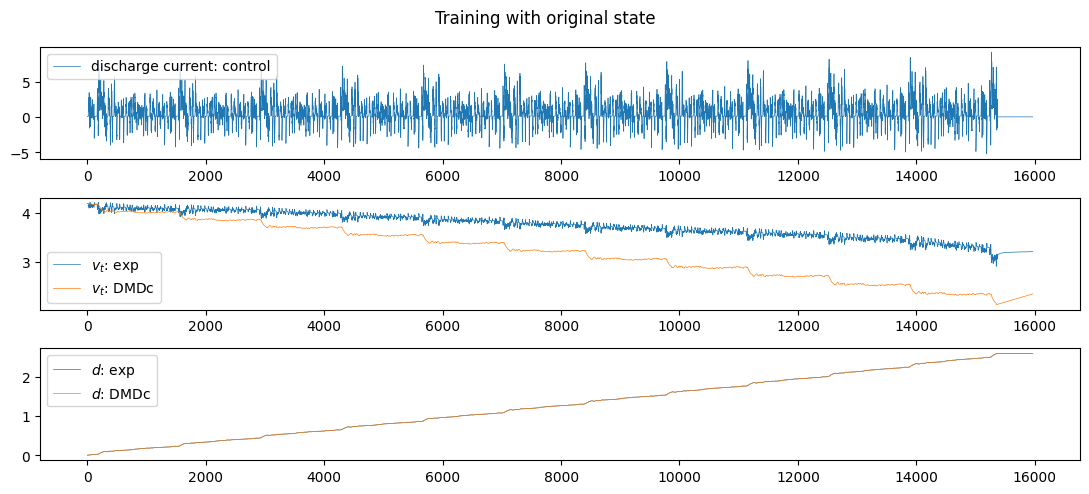

In [5]:
initial_state = state_data[:, 0]

pred_state = simulate_dmdc(Aest, Best, initial_state, U)

lw = 0.5
fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 5))
axs[0].plot(t_train, control_data[0,:], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[i, :], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_train, pred_state[i, :], label=state_names[i] + ": DMDc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Training with original state")
plt.tight_layout()
plt.show()

We can also compute aggregate error quantities as follows:

In [6]:
def compute_prediction_error(pred_state, state_data):
    rms_err = []
    for y, x in zip(pred_state, state_data):
        rms_err.append(np.sqrt(np.average((y - x) ** 2)))
    return rms_err


print("RMS: error:", compute_prediction_error(pred_state, state_data))

RMS: error: [0.6352260126484407, 0.0010199624501627948]


## Augmenting the DMDc state
In the above results. we note that while the model predicts $d$ quite reliably, the predictions of $v_t$ have a very large error. To fix, this, one can augment the state vector with features that are functions of the state vector. By augmenting the state with additional features, we are already performing *extended* DMD. However, we will cover extended DMD in more detail in the next tutorial.

In [this article](https://doi.org/10.1016/j.aej.2022.04.037), the authors suggest using additional features of $\phi_1 = 1/v_t^2$ and $\phi_2 = \exp (-\frac{1}{2 v_t^2})$. Let's try augmenting the state with these additional features and re-estimate the following DMDc system:

\begin{align}
\begin{pmatrix}
v_t[k+1] \\ d[k+1] \\ \phi_1[k+1] \\ \phi_2[k+1]
\end{pmatrix} = 
A 
\begin{pmatrix}
v_t[k] \\ d[k]  \\ \phi_1[k] \\ \phi_2[k]
\end{pmatrix} +
B
\left( i[k] \right),
\end{align},

where $A\in \mathbb{R}^{4 \times 4}$ and $B\in \mathbb{R}^{1 \times 1}$.

Note that there are two ways to work with the above system once $A$ and $B$ have been estimated. In the first method, one can the initial values of $v_t[0]$ and $d_t[0]$ to compute the initial values of $\phi_1[0]$ and $\phi_2[0]$. Subsequently, we can let the state evolve with the above equations without any changes at each timestep. In the second method, at the end of each time-step, we can take the dynamics output $v_t[k+1]$ and $d[k+1]$ and recompute $\phi_1[k+1]$ and $\phi_2[k+1]$ from $v_t[k+1]$ and $d[k+1]$ based on our definitions of $\phi_1$ and $\phi_2$. Thus, after every timestep, the evolved $\phi_1[k+1]$ and $\phi_2[k+1]$ are discarded and replaced with their new values based on evolved $v_t[k+1]$ and $d[k+1]$. In what follows, we demonstrate the first method. The second method is demonstrated in the next tutorial on extended DMDc.

In [7]:
# create augmented state
state_names = ["$v_t$", "$d$", "$\phi_1$", "$\phi_2$"]
f_phi1 = lambda x: 1 / x**2
f_phi2 = lambda x: np.exp(1.0 / 2 / x**2)
state_data = np.vstack([vt_train, d_train, f_phi1(vt_train), f_phi2(vt_train)])
control_data = curr_train.reshape((1, curr_train.size))


X = state_data[:, :-1]  # State at time k
X_prime = state_data[:, 1:]  # State at time k+1
U = control_data[:, :-1]  # Control input at time k

# Compute A and B matrices
Aest, Best = compute_dmdc_matrices(X, X_prime, U)

print("Estimated A and B matrices:")
print("A matrix:")
print(Aest)

print("B matrix:")
print(Best)

Estimated A and B matrices:
A matrix:
[[ 9.74288727e-01 -4.68933614e-03 -3.63239828e-01  1.24116965e-01]
 [ 2.05157949e-05  1.00000373e+00  2.89099113e-04 -9.88749870e-05]
 [ 1.03526993e-03  1.90127493e-04  1.01453464e+00 -4.99292652e-03]
 [ 5.37788563e-04  9.87835817e-05  7.54895958e-03  9.97406406e-01]]
B matrix:
[[-3.94937765e-04]
 [ 2.78929873e-05]
 [ 1.61247146e-05]
 [ 8.37949564e-06]]


RMS: error: [0.03951159841768982, 0.000426446050536057, 0.0026201386446963173, 0.0013785545009066852]


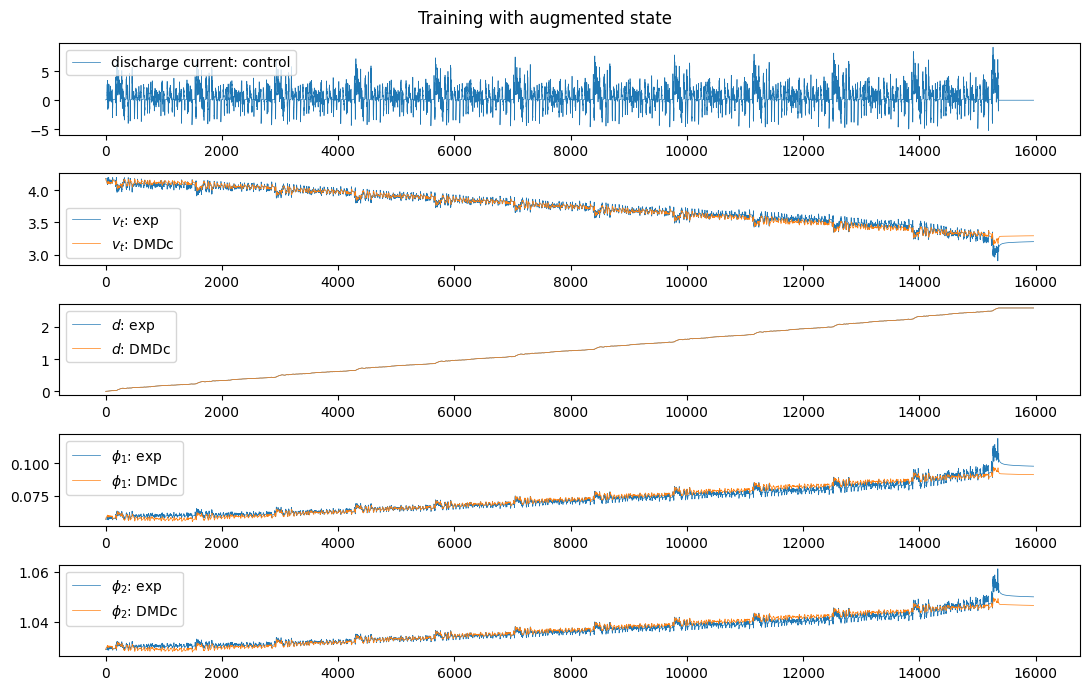

In [8]:
initial_state = state_data[:, 0]

pred_state = simulate_dmdc(Aest, Best, initial_state, U)

print("RMS: error:", compute_prediction_error(pred_state, state_data))

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_train, control_data[0,:], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[i, :], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_train, pred_state[i, :], label=state_names[i] + ": DMDc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Training with augmented state")
plt.tight_layout()
plt.show()

The learnt data-driven model is not perfect, but indeed much better than the previous version. We can test the models performance on unseen data for validation

RMS: error: [0.05133990890059417, 0.0043276618198950555, 0.0032885498755265163, 0.0017280453902430379]


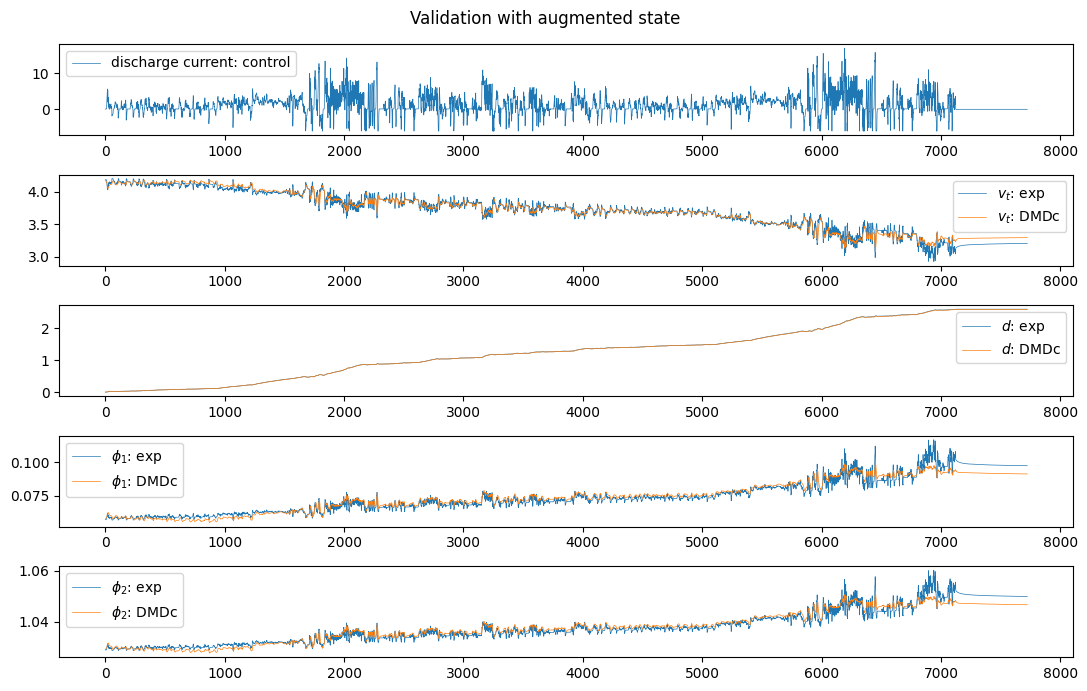

In [9]:
state_data = np.vstack([vt_val, d_val, f_phi1(vt_val), f_phi2(vt_val)])
control_data = curr_val.reshape((1, curr_val.size))

initial_state = state_data[:, 0]
pred_state = simulate_dmdc(Aest, Best, initial_state, control_data[:, :-1])

print("RMS: error:", compute_prediction_error(pred_state, state_data))

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(t_val, control_data[0, :], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_val, state_data[i, :], label=state_names[i] + ": exp", lw=lw)
    ax.plot(t_val, pred_state[i, :], label=state_names[i] + ": DMDc", lw=lw)
    ax.legend(loc="best")
fig.suptitle("Validation with augmented state")
plt.tight_layout()
plt.show()

One may try to improve the data-driven model further by using additional features, or consider alternative algorithms such as the extended DMDc and/or SINDy. These alternative algorithms are showcased in subsequent tutorials.

## Including the DMDc model in Collimator

Similarly to the previous tutorials in this series, ultimately our goal is to be able to include the battery model in Collimator, so that it can be utilised in a wider system model.

To achieve this, we can write two additional LeafSystems as shown below. The `DiscreteLinearSystem` effectively simulates the discrete dynamics $\mathbf{x}[k+1] = A\, \mathbf{x}[k] + B \; \mathbf{u}[k]$, and the `DiscreteSource` system provides the discrete control input sequence. For the latter, one may also utilise the pre-built `DataSource` in Collimator (see Collimator documentation and source: `/library/data_source.py`).

In [10]:
import collimator
from collimator.framework import LeafSystem
from collimator.library import Constant

from collimator.simulation import SimulatorOptions, ODESolverOptions

from typing import NamedTuple


class DiscreteLinearSystem(LeafSystem):
    """
    x[k+1] = A x[k] + B u[k]
    """

    def __init__(self, A, B, dt, initial_state=None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.A = A
        self.B = B
        self.nx, self.nu = B.shape
        self.dt = dt

        self.declare_input_port()

        if initial_state is None:
            initial_state = jnp.zeros(nx)

        self.declare_discrete_state(default_value=initial_state)

        self.declare_periodic_update(
            self._update_state,
            period=self.dt,
            offset=0.0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=initial_state,
            period=self.dt,
            offset=0.0,
            requires_inputs=False
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state

    def _update_state(self, time, state, u, **params):
        x = state.discrete_state
        # Dynamics: y = Ax + Bu
        y = jnp.matmul(self.A, x) + jnp.matmul(self.B, jnp.atleast_1d(u))
        return y


class DiscreteSource(LeafSystem):
    class DiscreteStateType(NamedTuple):
        index: jnp.int64
        source_val: jnp.float64

    def __init__(self, val_array, dt, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.val_array = val_array
        self.dt = dt

        self.declare_discrete_state(
            default_value=self.DiscreteStateType(index=0, source_val=val_array[0]),
            as_array=False,
        )

        self.declare_periodic_update(
            self._update,
            period=self.dt,
            offset=0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=self.val_array[0],
            period=self.dt,
            offset=0.0,
            requires_inputs = False,
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state.source_val

    def _update(self, time, state, *inputs, **params):
        index = state.discrete_state.index
        index = index + 1
        source_val = self.val_array[index]
        return self.DiscreteStateType(index=index, source_val=source_val)

We can now include the learnt data-driven system in Collimator and simulate.

In [11]:
builder = collimator.DiagramBuilder()
initial_state = jnp.array(
    [vt_train[0], d_train[0], f_phi1(vt_train[0]), f_phi2(vt_train[0])]
)
dt = 0.1

dls = builder.add(
    DiscreteLinearSystem(
        jnp.array(Aest), jnp.array(Best), dt=dt, initial_state=initial_state, name="dls"
    )
)
control = builder.add(DiscreteSource(jnp.array(curr_train), dt=dt, name="control"))

builder.connect(control.output_ports[0], dls.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {
    "state": diagram["dls"].output_ports[0],
    "control": diagram["control"].output_ports[0],
}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


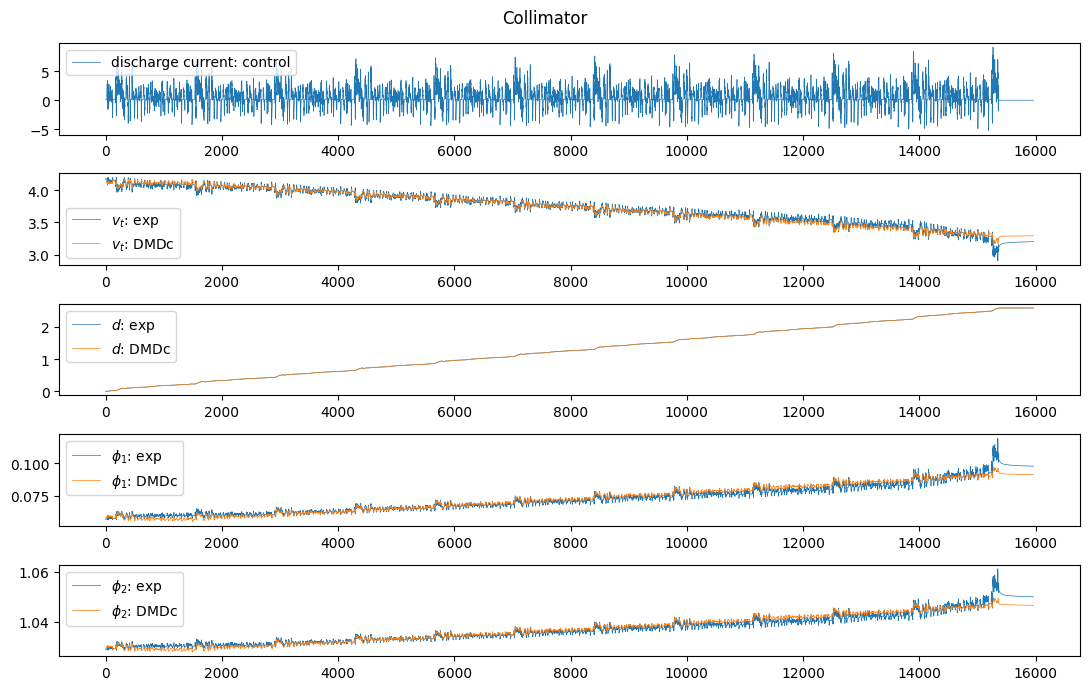

In [12]:
state_data = np.vstack(
    [vt_train, d_train, f_phi1(vt_train), f_phi2(vt_train)]
)  # exp data for plotting

fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(sol.time, sol.outputs["control"], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[i, :], label=state_names[i] + ": exp", lw=lw)
    ax.plot(
        sol.time, sol.outputs["state"][:, i], label=state_names[i] + ": DMDc", lw=lw
    )
    ax.legend(loc="best")
fig.suptitle("Collimator")
plt.tight_layout()
plt.show()

## Training the DMDc model as part of the Collimator block

We could go a step further and include the DMDc training within the Collimator block. This is helpful where you want to incorporate all preprocessing within the Collimator block and create your own library of reusable blocks. We show this below by modifying the `DiscreteLinearSystem` to a `DiscreteDMDc` block.

In [13]:
class DiscreteDMDc(LeafSystem):
    """
    Compute DMDc matrices A and B from the training data.
    Subsequently implement the following discrete-time system
    x[k+1] = A x[k] + B u[k]
    """

    def __init__(self, state_data, control_data, dt, initial_state=None, *args, **kwargs):
        super().__init__(*args, **kwargs)

        self.state_data = state_data
        self.control_data = control_data
        self.dt = dt
        
        self._compute_dmdc()
        
        self.declare_input_port()

        if initial_state is None:
            initial_state = jnp.zeros(nx)

        self.declare_discrete_state(default_value=initial_state)

        self.declare_periodic_update(
            self._update_state,
            period=self.dt,
            offset=0.0,
        )

        self.declare_output_port(
            self._compute_output,
            default_value=initial_state,
            period=self.dt,
            offset=0.0,
            requires_inputs=False
        )

    def _compute_output(self, time, state, **params):
        return state.discrete_state

    def _update_state(self, time, state, u, **params):
        x = state.discrete_state
        # Dynamics: y = Ax + Bu
        y = jnp.matmul(self.A, x) + jnp.matmul(self.B, jnp.atleast_1d(u))
        return y

    def _compute_dmdc(self):
        X = self.state_data[:, :-1]  # State at time k
        X_prime = self.state_data[:, 1:]  # State at time k+1
        U = self.control_data[:, :-1]  # Control input at time k
        
        # Perform SVD on the data matrix
        Omega = np.vstack((X, U))
        U_omega, Sigma_omega, V_omega = np.linalg.svd(Omega, full_matrices=False)
    
        # Truncate to rank-r (optional, here we keep all components)
        r = min(Sigma_omega.size, Omega.shape[0], Omega.shape[1])
        U_omega_r = U_omega[:, :r]
        Sigma_omega_r = np.diag(Sigma_omega[:r])
        V_omega_r = V_omega[:r, :]
    
        # Compute A and B
        A_tilde = X_prime @ V_omega_r.T @ np.linalg.inv(Sigma_omega_r) @ U_omega_r[:X.shape[0], :].T
        B_tilde = X_prime @ V_omega_r.T @ np.linalg.inv(Sigma_omega_r) @ U_omega_r[X.shape[0]:, :].T
    
        self.A = A_tilde
        self.B = B_tilde
        self.nx, self.nu = self.B.shape

In [14]:
state_data = np.vstack([vt_train, d_train, f_phi1(vt_train), f_phi2(vt_train)])
control_data = curr_train.reshape((1, curr_train.size))

builder = collimator.DiagramBuilder()

dmdc = builder.add(
    DiscreteDMDc(
        state_data, control_data, dt=dt, initial_state=initial_state, name="dmdc"
    )
)

control = builder.add(DiscreteSource(jnp.array(curr_train), dt=dt, name="control"))

builder.connect(control.output_ports[0], dmdc.input_ports[0])

diagram = builder.build()
context = diagram.create_context()

recorded_signals = {
    "state": diagram["dmdc"].output_ports[0],
    "control": diagram["control"].output_ports[0],
}

options = SimulatorOptions(max_major_steps=ceil(t_train[-1] / dt))
sol = collimator.simulate(
    diagram,
    context,
    (0.0, t_train[-1]),
    options=options,
    recorded_signals=recorded_signals,
)

collimator:INFO Simulator ready to start: SimulatorOptions(math_backend=jax, enable_tracing=True, max_major_step_length=None, max_major_steps=159656, ode_solver_method=auto, rtol=1e-06, atol=1e-08, min_minor_step_size=None, max_minor_step_size=None, zc_bisection_loop_count=40, save_time_series=True, recorded_signals=2, return_context=True), Dopri5Solver(system=Diagram(root, 2 nodes), rtol=1e-06, atol=1e-08, max_step_size=None, min_step_size=None, method='auto', enable_autodiff=False, supports_mass_matrix=False)


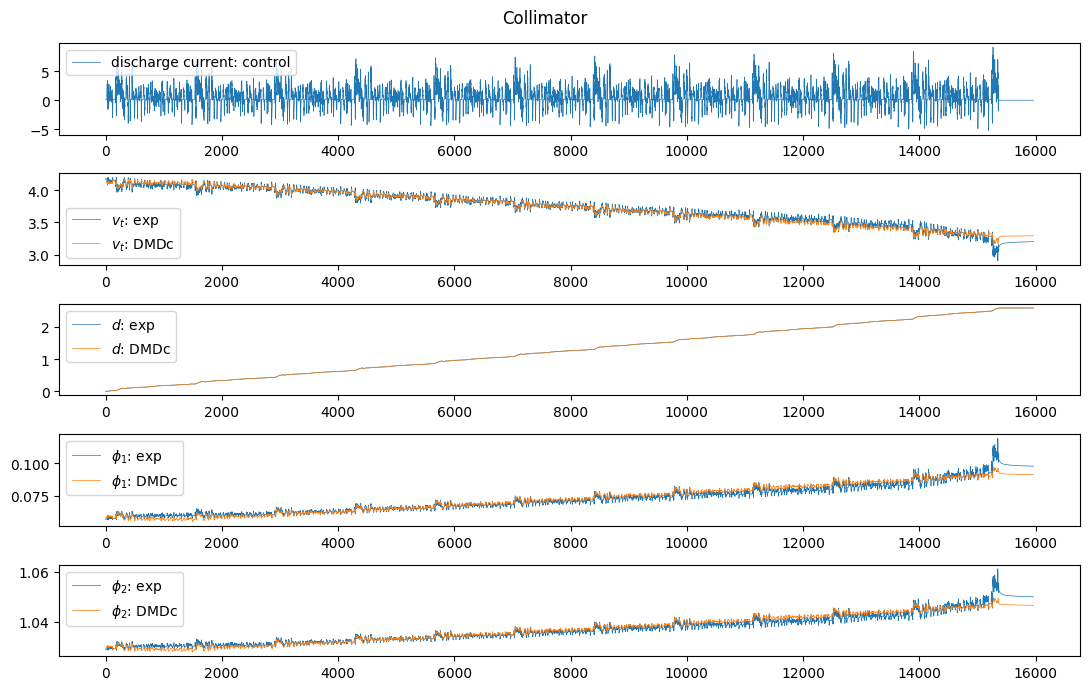

In [15]:
fig, axs = plt.subplots(len(state_names) + 1, 1, figsize=(11, 7))
axs[0].plot(sol.time, sol.outputs["control"], label="discharge current: control", lw=lw)
axs[0].legend()
for i, ax in enumerate(axs[1:]):
    ax.plot(t_train, state_data[i, :], label=state_names[i] + ": exp", lw=lw)
    ax.plot(
        sol.time, sol.outputs["state"][:, i], label=state_names[i] + ": DMDc", lw=lw
    )
    ax.legend(loc="best")
fig.suptitle("Collimator")
plt.tight_layout()
plt.show()